[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sloomba/connectivity/blob/master/connectivity_kernel.ipynb)

In [0]:
!pip install -q tensorflow-probability

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import networkx as nx
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tfp.positive_semidefinite_kernels
from tensorflow_probability import edward2 as ed

In [0]:
from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.positive_semidefinite_kernels.internal import util
class LogisticKernel(tfk.PositiveSemidefiniteKernel):
  """The LogisticKernel kernel, has the form
    ```none
    k(x, y) = w_0 + W' * |x - y|
    ```
  where the bars represent absolute, x and y are vectors, W is a "weight" vector
  and w_0 controls baseline "edge density".
  """

  def __init__(self,
               edge_density=None,
               weights=None,
               feature_ndims=1,
               name='LogisticKernel'):
    """Construct a LogisticKernel kernel instance.
    Args:
      edge_density: floating point `Tensor` that controls the baseline edge 
        density in the network
      feature_ndims: Python `int` number of rightmost dims to include
      name: Python `str` name prefixed to Ops created by this class.
    """
    with tf.name_scope(name, values=[edge_density, weights]) as name:
      dtype = dtype_util.common_dtype([edge_density, weights], tf.float32)
      if edge_density is not None:
        edge_density = tf.convert_to_tensor(
          edge_density, name='edge_density', dtype=dtype)
      self._edge_density = edge_density
      if weights is not None:
        weights = tf.convert_to_tensor(
            weights, name='weights', dtype=dtype)
      self._weights = weights
      tf.assert_same_float_dtype([self._edge_density, self._weights])
    super(LogisticKernel, self).__init__(
        feature_ndims, dtype=dtype, name=name)

  @property
  def edge_density(self):
    """Edge density parameter."""
    return self._edge_density

  @property
  def weights(self):
    """Weights parameter."""
    return self._weights

  def _batch_shape(self):
    scalar_shape = tf.TensorShape([])
    return tf.broadcast_static_shape(
        scalar_shape if self.edge_density is None else self.edge_density.shape,
        scalar_shape if self.weights is None else self.weights.shape)

  def _batch_shape_tensor(self):
    return tf.broadcast_dynamic_shape(
        [] if self.edge_density is None else tf.shape(self.edge_density),
        [] if self.weights is None else tf.shape(self.weights))

  def _apply(self, x1, x2, param_expansion_ndims=0):
    if self.weights is not None:
      weights = util.pad_shape_right_with_ones(
          self.weights, param_expansion_ndims)
      kval = util.sum_rightmost_ndims_preserving_shape(
          tf.multiply(tf.abs(tf.subtract(x1, x2)), weights), self.feature_ndims)
    else:
      kval = util.sum_rightmost_ndims_preserving_shape(
          tf.abs(tf.subtract(x1, x2)), self.feature_ndims)

    if self.edge_density is not None:
      edge_density = util.pad_shape_right_with_ones(
          self.edge_density, param_expansion_ndims)
      kval += edge_density

    return tf.sigmoid(kval)

In [0]:
def connectivity_kernel(x, num_samples=50, blau_dims=2, cauchy_scale=1.):
  """Defines the probabilistic connectivity kernel.
  
  This function defines a fully probabilistic Logistic kernel, by placing
  Cauchy priors on the kernel parameters (edge density and weights) and
  treating edges as a Bernoulli random variable conditioned on the kernel
  output.
  
  Args:
    x (tf.Tensor): a rank-2 tensor object representing n samples in a d
      dimensional Blau space
    cauchy_scale (float): a positive float  representing scale of the Gamma 
      prior on the scale of the Cauchy priors on kernel parameters
      
  Returns:
    rv_edge_density (ed.Cauchy): a Cauchy-distributed random variable 
      representing priors on the edge density of the Logistic kernel
    rv_weights (ed.Cauchy): a Cauchy-distributed random variable 
      representing priors on the weights of the Logistic kernel
    rv_edges (ed.Bernoulli): a Bernoulli-distributed random variable
      representing probability of an "edge" conditioned on the kernel
    rv_cauchy_scale (ed.Gamma): a Gamma-distributed random variable 
      representing prior on the scale of the Cauchy priors on kernel parameters
  """  
  rv_edge_density = ed.Normal(loc=0., scale=1.0, name='edge_density')
  rv_cauchy_scale = ed.Gamma(concentration=cauchy_scale, rate=1., 
                             name='cauchy_scale_prior')
  rv_weights = ed.Cauchy(loc=0., scale=rv_cauchy_scale*tf.ones(blau_dims), 
                         name='weights')
  kernel = LogisticKernel(
      edge_density=rv_edge_density, weights=rv_weights, 
      feature_ndims=blau_dims)
  intaxn = tf.concat([
      tf.stack([kernel.apply(x[i,:], x[j,:]) for j in range(i)]) 
      for i in range(1, num_samples)], -1)
  rv_edges = ed.Bernoulli(probs=intaxn, name='edge_probability')
  return rv_edge_density, rv_weights, rv_edges, rv_cauchy_scale

In [0]:
def social_isolation(x, kernel, spins=None):
  """Calculates social isolation of points in a Blau space.
  
  Given a Logistic kernel and points in a Blau space, estimates pairwise 
  social isolation between all individuals in the space. Also "marginalizes"
  over to compute individual-level social isolation.
  
  Args:
    x (np.ndarray): a numpy matrix(nxd) representing n samples in a d
      dimensional Blau space
    kernel ((edge_density, weight)): a tuple of edge_density (scalar) and 
      weight (sequence/list of length equal to number of Blau dimensions)
    spins (np.ndarray): a numpy vector representing spin (+/-1) of the points
    
  Returns:
    separn (np.ndarray): a numpy matrix(nxn) representing pairwise separation
  """
  kernel = LogisticKernel(edge_density=kernel[0], weights=kernel[1], 
                          feature_ndims=len(kernel[1]))
  intaxn = tf.stack([
      tf.stack([kernel.apply(x[i,:], x[j,:]) for j in range(x.shape[0])]) 
      for i in range(x.shape[0])], axis=0)
  with tf.Session() as sess:
    intaxn = sess.run(intaxn)
  separn = -1*np.log(intaxn/(np.diag(intaxn)[:,None]))
  separn_ind = np.sum(separn, axis=1)
  if spins is None:
    plt.scatter(x=x[:,0], y=x[:,1], c=separn_ind)
  else:
    plt.scatter(x=x[spins==1,0], y=x[spins==1,1], 
                c=separn_ind[spins==1], marker='+')
    plt.scatter(x=x[spins==-1,0], y=x[spins==-1,1], 
                c=separn_ind[spins==-1], marker='o')
  plt.colorbar()
  return separn 

In [0]:
def spins2net(spins):
  spins = tf.expand_dims(spins,-1)
  net = tf.cast((tf.matmul(spins, spins, transpose_b=True) + 1)/2, 
                   dtype=tf.int32)
  return net

In [0]:
def infer_kernel_adam(x, net, num_epochs=100, print_window=5):
  """Inferring connectivity kernel.
  
  This TensorFlow program does a MAP estimation of the parameters of a 
  probabilistic connectivity kernel. It uses Edward2 to define a probabilistic 
  program and the joint log likelihood, and then perform inference of kernel 
  parameters using the Adam optimizer.
  
  Args:
    x (tf.Tensor): a rank-2 tensor(nxd) object representing n samples in a d
      dimensional Blau space
    net (tf.Tensor): a rank-2 tensor(nxn) object representing (symmetric) 
      adjacency matrix
    num_epochs (int): a positive int for number of epochs to run Adam for
    print_window (int): a positive int for plot printing step
  """
  num_samples = x.shape[0]
  blau_dims = x.shape[1]
  x = tf.Constant(x, np.float32)
  edge_density = tf.Variable(0., dtype=np.float32)
  weights = tf.Variable(np.zeros(BLAU_DIMS), dtype=np.float32)
  cauchy_scale_prior = tf.Variable(1., dtype=tf.float32)
  edges = tf.concat([tf.stack([net[i,j] for j in range(i)]) 
                      for i in range(1, num_samples)], -1)
  log_joint = ed.make_log_joint_fn(connectivity_kernel)
  
  def log_cond(edge_density, weights, cauchy_scale_prior):
    return log_joint(x, num_samples, blau_dims, 
                     edge_density=edge_density, weights=weights, 
                     edge_probability=edges, 
                     cauchy_scale_prior=cauchy_scale_prior)

  neg_log_like = -1*log_cond(edge_density, weights, cauchy_scale_prior)
  optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
  train = optimizer.minimize(neg_log_like)
  init = tf.global_variables_initializer()
  t = []
  with tf.Session() as sess:
    sess.run(init)
    for i in range(num_epochs):
      sess.run(train)
      if i % print_window == 0:
        cnll, cwd, cw, ccsp = sess.run([
            neg_log_like, edge_density, weights, cauchy_scale_prior])
        t.append(cnll)
    edge_density_map = sess.run(edge_density)
    weights_map = sess.run(weights)
    cauchy_scale_prior_map = sess.run(cauchy_scale_prior)
  plt.plot(range(1, num_epochs, print_window), t)
  return edge_density_map, weights_map, cauchy_scale_prior_map

In [0]:
def opiniated_gaussian_mixtures(num_samples=50, num_components=3, 
                                mean_scale=[1., 4.], sigma_scale=1.,
                                ind_dim=True,
                                p_opinion=[0.9, 0.1, 0.5], p_component=None, 
                                dims=2, df=4, state=None):
  """Generates people in a Gaussian mixture Blau space. 
  """
  if not isinstance(mean_scale, list):
    mean_scale = [mean_scale for i in range(dims)]
  for s in mean_scale: assert(s>=0.)
  assert(len(mean_scale)==dims)
  
  if not isinstance(sigma_scale, list):
    sigma_scale = [sigma_scale for i in range(dims)]
  for s in sigma_scale: assert(s>=0.)
  assert(len(sigma_scale)==dims)
    
  if not isinstance(p_opinion, list):
    p_opinion = [p_opinion for i in range(num_components)]
  for p in p_opinion: assert(0.<=p<=1.)
  assert(len(p_opinion)==num_components)
  
  if p_component is None:
    p_component = [1./num_components for i in range(num_components)]
  for p in p_component: assert(0.<=p<=1.)
  assert(len(p_component)==num_components)
  assert(sum(p_component)==1)
  
  assert(df>=dims+1)
  
  import scipy.stats as stat
  component_means = np.transpose(
      np.vstack([stat.norm.rvs(scale=s, size=num_components, 
                               random_state=state) for s in mean_scale]))
  if ind_dim:
    component_vars = np.transpose(
        np.vstack([stat.gamma.rvs(a=s, size=num_components, 
                                  random_state=state) for s in sigma_scale]))
    component_vars = np.squeeze(np.stack(np.expand_dims(
        [np.diag(component_vars[i,:]) for i in range(component_vars.shape[0])], 
        axis=0)), axis=0)
  else:
    component_vars = stat.invwishart.rvs(df, np.diag(sigma_scale), 
                                         size=num_components)
  assignments = stat.multinomial.rvs(1, p_component, 
                                     size=num_samples, random_state=state)
  p_opinion_ = assignments.dot(p_opinion)
  assignments = np.nonzero(assignments)[1]
  opinions = 2*np.array([stat.bernoulli.rvs(p) for p in p_opinion_])-1
  
  points = np.array([stat.multivariate_normal.rvs(
      mean=component_means[i,:], cov=component_vars[i,:,:]) 
                    for i in assignments], dtype=np.float32)
  plt.scatter(x=points[opinions==1,0], y=points[opinions==1,1], 
              c=assignments[opinions==1], marker='+')
  plt.scatter(x=points[opinions==-1,0], y=points[opinions==-1,1], 
              c=assignments[opinions==-1], marker='o')
  return {'coords':points, 'spins':opinions, 'component':assignments, 
          'mean':component_means, 'covariance': component_vars}

In [0]:
def generate_blau_data(num_samples=50, dims=2, state=16):
  import scipy.stats as stat
  points = np.array(stat.uniform.rvs(size=[num_samples, dims], 
                                     random_state=state), dtype=np.float32)
  with tf.Session() as sess:
    kernel_sample = sess.run(connectivity_kernel(points, num_samples, dims))
  G = nx.Graph()
  G.add_nodes_from([i for i in range(num_samples)])
  idx = 0
  adj_mat = np.zeros([num_samples, num_samples], dtype=np.int32)
  for i in range(1, num_samples):
    for j in range(i):
      if kernel_sample[2][idx]==1:
        G.add_edge(i, j)
        adj_mat[i,j] = 1
        adj_mat[j,i] = 1
      idx += 1
  nx.draw(G, pos=points) 
  return {'coords':points, 'network':adj_mat, 'kernel':kernel_sample}

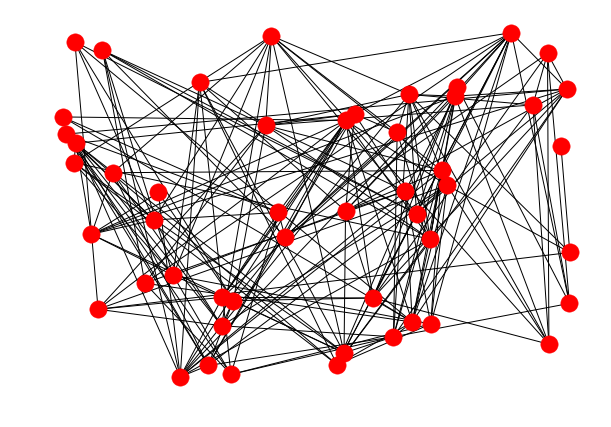

In [86]:
train_data = generate_blau_data()

In [87]:
train_data['kernel']

(-0.7299229,
 array([-3.512064  ,  0.23973331], dtype=float32),
 array([0, 1, 0, ..., 0, 0, 0], dtype=int32),
 0.21032922)

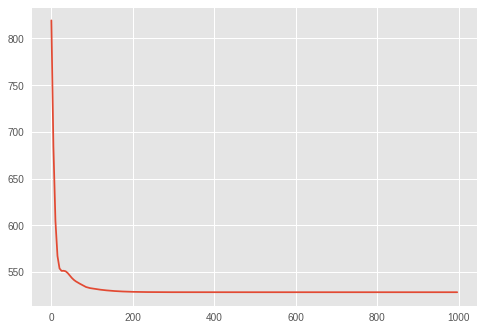

In [90]:
conn_kernel = infer_kernel_adam(train_data['coords'], train_data['network'], num_epochs=1000)

In [91]:
conn_kernel

(-1.0216548, array([-2.7306771,  0.6530624], dtype=float32), 0.73956674)

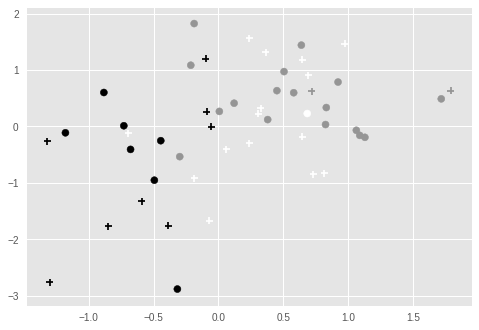

In [11]:
blau_points = opiniated_gaussian_mixtures()

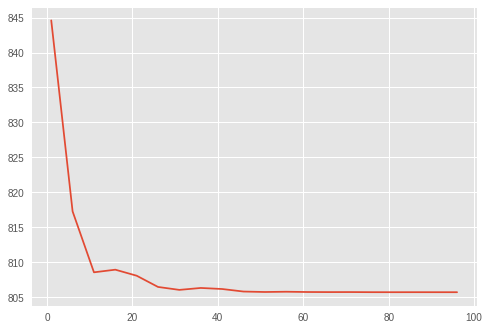

In [76]:
x = tf.constant(blau_points['coords'], np.float32)
y = tf.expand_dims(tf.constant(blau_points['spins'], np.int32),-1)
conn_kernel = infer_kernel_adam(x, y)

In [77]:
conn_kernel

(0.59361756, array([ 0.13248546, -0.31945783], dtype=float32), 0.48588443)

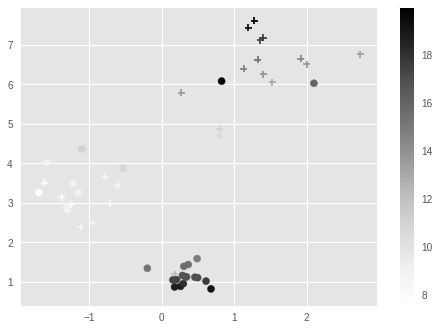

In [78]:
sii = social_isolation(blau_points['coords'], conn_kernel, blau_points['spins'])

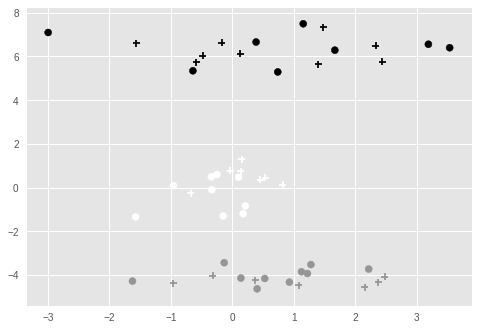

In [59]:
blau_points_equi = opiniated_gaussian_mixtures(p_opinion=.5)

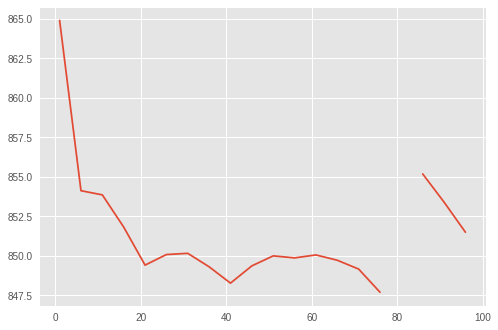

In [79]:
x = tf.constant(blau_points_equi['coords'], np.float32)
y = tf.expand_dims(tf.constant(blau_points_equi['spins'], np.int32),-1)
conn_kernel_equi = infer_kernel_adam(x, y)

In [80]:
conn_kernel_equi

(0.008829469, array([-0.00564963, -0.0069623 ], dtype=float32), 0.2959434)

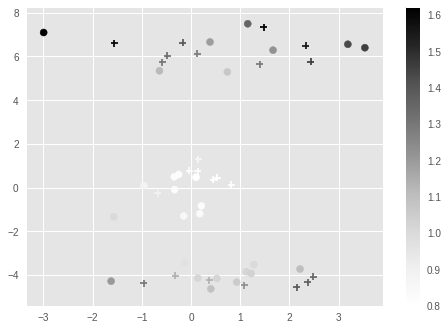

In [81]:
sii_equi = social_isolation(blau_points_equi['coords'], conn_kernel_equi, blau_points_equi['spins'])

Negative SII without the Gamma prior on scale of Cauchy prior!

MCMC for posteriors.

Matt's RGG as data

Till's codebase

Understanding society survey.

Data generative process should match the inference.

658